# Annotate integrated dataset via projection on HCA-BM (Manton) cells dataset

In [1]:
%matplotlib widget

import warnings
warnings.filterwarnings('ignore')

import os, sys, math, re
import natsort, json, operator, getpass
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd

import scanpy as sc
import scanpy.external as sce

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import ipywidgets as widgets

In [2]:
with open('/.singularity.d/labels.json') as fh:
    singularity = json.load(fh)
    
singularity['Version']

'metztli.25j'

In [3]:
sc.settings.verbosity = 3             # show some output
sc.settings.file_format_figs = 'svg'  # set this to 'svg' (notebook) or 'pdf' (files) if you want vector graphics
sc.settings.savefigs = False

In [4]:
home = str(Path.home())
user = getpass.getuser()

In [5]:
"""
Allows to create a persistent png image from
the last plotted matplotlib plot widget
"""
def perma_plot():
    
    import base64
    from io import BytesIO
    from IPython.display import HTML
    
    # TODO: maybe pass parameters for savefig
    #       to control quality/type of img
    buffer = BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0)
    
    encoded_string = base64.b64encode(buffer.read()).decode('utf-8')
    html_string = '<img src=\'data:image/png;base64,{}\'>'.format(encoded_string)
    
    return HTML(html_string)

---

In [6]:
basedir = os.path.join(home, 'databoard/users', user)

sc.settings.writedir = os.path.join(basedir, '2021/BloodPaper/h5ad/')

In [7]:
now = datetime.now()
prefix = now.strftime('%Y%m%d')
print(prefix)

20211119


### HCA BM cells

In [8]:
hcapath = os.path.join(basedir, '2021/HCABM/h5ad')

target_hca = sc.read(os.path.join(hcapath, '20210707_HCA_BM_HSCMPP_cells'))

In [9]:
combo10 = sc.read('20211117_COMBO10_original_standard_working_clean_version')

In [10]:
target_hca.X.min(), target_hca.X.max()

(0.0, 7.838901)

In [11]:
combo10.X.min(), combo10.X.max()

(0.0, 9.661618)

The datasets need to be defined on the same variables.

In [12]:
var_names = target_hca.var_names.intersection(combo10.var_names)

ref = target_hca[:, var_names].copy()
target = combo10[:, var_names].copy()

In [13]:
ref[:, var_names].shape

(8426, 21828)

Get the Seurat-integrated dataset (pre-'frankenstein')

In [14]:
sourcedir = os.path.join(basedir, '2020/SLX19841/analysis/h5ad/')

integrated = sc.read( os.path.join(sourcedir, '20210108_COMBO10_NO_SPL3_Seurat3_data_integrated.h5ad') )
integrated.shape

(118783, 2000)

In [16]:
# I just need the reference subset cells from it
raw_adata = integrated[target.obs_names, :].raw.to_adata()
raw_adata.var.index = raw_adata.var['_index']
raw_adata

AnnData object with n_obs × n_vars = 117200 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'donor', 'organ', 'integrated_snn_res.0.8', 'seurat_clusters'
    var: '_index'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_umap'

Now just the genes common in the **integration**, (processed) **reference** and the **target**

In [17]:
ref = ref[:, var_names.intersection(raw_adata.var_names)].copy()
target = target[:, var_names.intersection(raw_adata.var_names)].copy()

In [18]:
ref.shape, target.shape

((8426, 1947), (117200, 1947))

In [19]:
ref

AnnData object with n_obs × n_vars = 8426 × 1947
    obs: 'donor', 'run', 'donor_run', 'n_genes', 'n_counts', 'doublet_score', 'predicted_doublets', 'predicted_doublets_tr025', 'remove_doublets_groups', 'S_score', 'G2M_score', 'phase', 'leiden', 'iwo', 'manton'
    var: 'gene_ids', 'mouseid', 'mousesymbol', 'n_cells', 'MTgenes', 'notMTgenes', 'n_counts', 'symbol', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'gene_removed'
    uns: 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'iwoln'
    obsp: 'connectivities', 'distances'

In [21]:
sc.pp.scale(ref)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [22]:
sc.pp.pca(ref, n_comps=30, use_highly_variable=False)

computing PCA
    with n_comps=30
    finished (0:00:01)


In [27]:
sc.pl.pca_scatter(ref, color='donor')
plt.subplots_adjust(right=0.75)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …


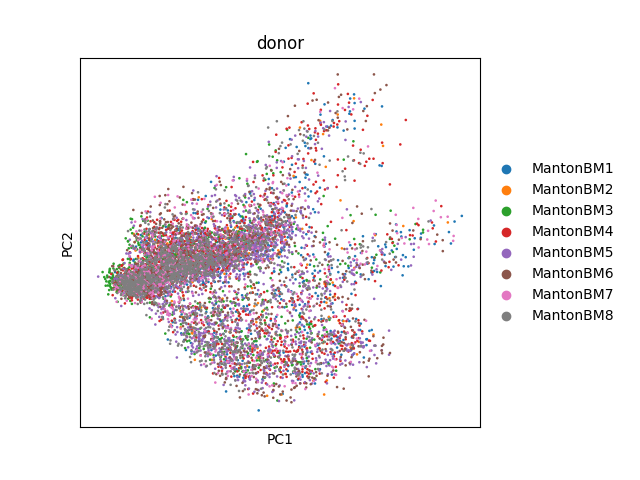

In [28]:
perma_plot()

In [29]:
%%time
sc.tl.draw_graph(ref, n_jobs=4, layout='drl')

drawing single-cell graph using layout 'drl'
    finished: added
    'X_draw_graph_drl', graph_drawing coordinates (adata.obsm) (0:00:26)
CPU times: user 26.9 s, sys: 94.9 ms, total: 27 s
Wall time: 26.9 s


In [30]:
sc.pl.embedding(ref, basis='draw_graph_drl', 
                color=['manton'], 
                wspace=0.1, 
                legend_loc='on data', 
                legend_fontsize='xx-small', 
                legend_fontweight='bold', 
                #labelspacing=0.75
               )

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …


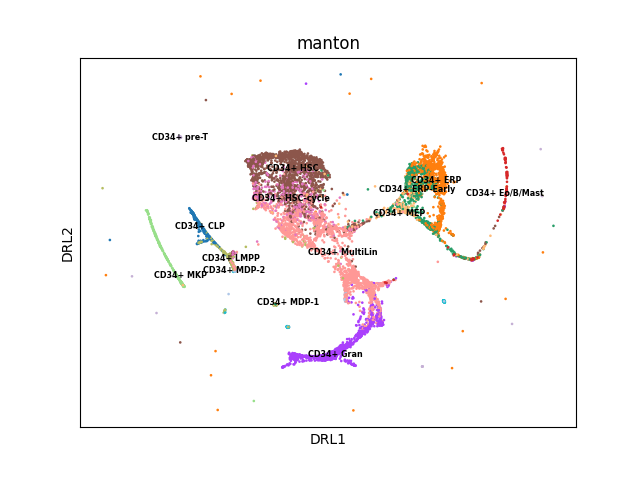

In [31]:
perma_plot()

In [34]:
import cellproject_master.cellproject as cp

In [35]:
%%time
umap_ref = cp.quick_umap(ref, rep_n_components=30)

CPU times: user 21 s, sys: 295 ms, total: 21.3 s
Wall time: 20.8 s


Stick the 'quick umap' embedding into the ref adata to check it out

In [36]:
ref.obsm['X_umap_2'] = umap_ref.embedding_.copy()

In [39]:
sc.pl.embedding(ref, basis='umap_2', color='manton')
plt.subplots_adjust(right=0.70)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …


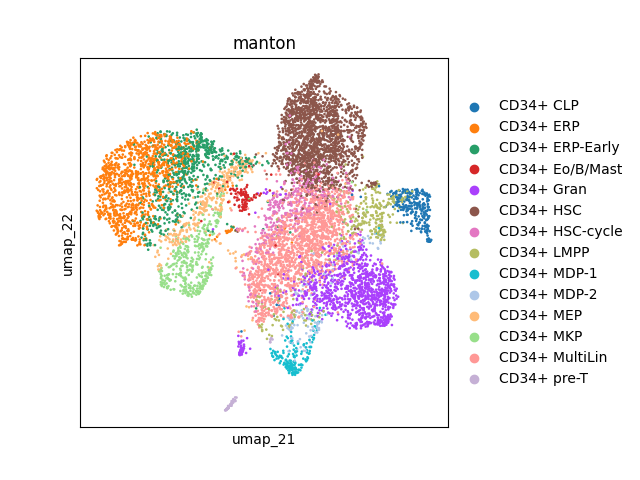

In [40]:
perma_plot()

In [41]:
def unclog_umap_caching(x) :
    
    import tempfile
    '''
    This is an ugly fix to allow fit_transform into an UMAP object,
    it gets rids of "TypeError: cannot pickle 'weakref' object" error
    Provide a UMAP object as x.
    IMPORTANT: this function will break the UMAP object, recompute
    afterwards.
    '''
    import pickle
    #  umap_ref._knn_search_index._visited = np.zeros((umap_ref._knn_search_index._raw_data.shape[0] // 8) + 1, dtype=np.uint8, order="C")
    for i in range(3):
        try:
            with tempfile.TemporaryFile() as f:
            #with open(file, 'wb') as f:
                pickle.dump(x, f)
        except:
            pass
    #  umap_ref._knn_search_index._vertex_order = umap_ref._knn_search_index._search_forest[0].indices

In [42]:
unclog_umap_caching(umap_ref)

In [43]:
umap_ref2 = cp.quick_umap(ref, rep_n_components=30)

In [44]:
target

AnnData object with n_obs × n_vars = 117200 × 1947
    obs: 'batch', 'n_counts', 'n_genes', 'mitoc_fraction', 'doublet_score', 'library', 'donor', 'organ', 'leiden.1.2', 'silhouette.1.2', 'dpt_pseudotime', 'dpt_pseudotime_rank', 'S_score', 'G2M_score', 'phase', 'annot'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dex_leiden_1_2', 'diffmap_evals', 'donor_colors', 'draw_graph', 'hvg', 'iroot', 'leiden', 'leiden.1.2_colors', 'log1p', 'neighbors', 'phase_colors'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_pca', 'X_umap'
    layers: 'counts', 'lognorm'
    obsp: 'connectivities', 'distances'

In [45]:
target.obsm['X_umap_seurat'] = target.obsm['X_umap'].copy()

In [46]:
%%time
cp.project_cells(target,
                  ref,
                  pca_n_components=None,
                  k=15,
                  obs_columns=['manton'],
                  fit_pca=True,
                  scale_data=True,
                  use_vargenes=False,
                  umap_ref=umap_ref2,
                  numeric_fun=np.mean,
                  categorical_how='mode',
                  copy=False)

Running a common scaling for target and reference data
Fitting target data (.X) into reference PC space
Using existing PCA rotation in .varm["PCs"]
Using the provided UMAP reference to fit new data
CPU times: user 3min 42s, sys: 5.17 s, total: 3min 47s
Wall time: 3min 46s


In [47]:
target.obs.head()

,batch,n_counts,n_genes,mitoc_fraction,doublet_score,library,donor,organ,leiden.1.2,silhouette.1.2,dpt_pseudotime,dpt_pseudotime_rank,S_score,G2M_score,phase,annot,ref_manton
_01_AAACCTGCACGTCTCT.1.0,0,10052.0,2399,0.027491,0.054662,SIGAD9,DOD1,PB,2,-0.095935,0.224698,66554.0,-0.156682,-0.062280,G1,02_MEP2,CD34+ MEP
_01_AAACCTGGTGTGACGA.1.0,0,14884.0,3610,0.030734,0.011152,SIGAD9,DOD1,PB,13,0.295117,0.396628,85875.0,0.383165,0.065524,S,13_MEP cycle,CD34+ ERP-Early
_01_AAACCTGGTTCCGGCA.1.0,0,5547.0,1544,0.042304,0.021956,SIGAD9,DOD1,PB,0,0.198961,0.082326,23761.0,-0.166414,-0.085699,G1,00_HSC/MPP2,CD34+ HSC
_01_AAACGGGGTCAAAGCG.1.0,0,4184.0,1159,0.026033,0.031721,SIGAD9,DOD1,PB,0,0.031663,0.097205,34985.0,-0.096252,-0.099328,G1,00_HSC/MPP2,CD34+ HSC
_01_AAAGATGCACATGACT.1.0,0,12027.0,2548,0.027215,0.096179,SIGAD9,DOD1,PB,0,0.034625,0.093352,32259.0,-0.135317,-0.064835,G1,00_HSC/MPP2,CD34+ HSC


In [49]:
sc.write(prefix+'_COMBO10_annotated_with_HCA_manton_via_cp', target)

In [57]:
sc.pl.embedding(target, basis='umap_seurat', 
                color=['annot', 'ref_manton'], 
                wspace=0.1, 
                legend_loc='on data', 
                legend_fontsize='xx-small', 
                legend_fontweight='bold'
               )

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …


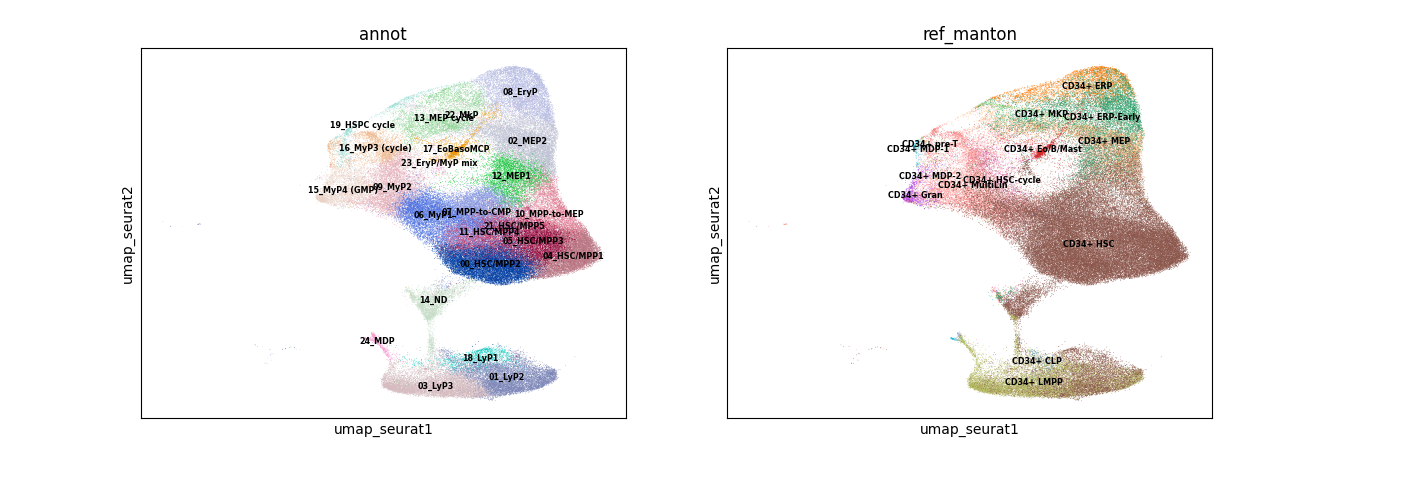

In [59]:
perma_plot()

In [60]:
plt.savefig('figures/'+prefix+'_COMBO10_HCA_manton_annotated_dual_UMAP.png', dpi=600)

### COMBO10 vs Manton annotations counts

In [61]:
target.obs.groupby(['annot', 'ref_manton']).size().unstack()

ref_manton,CD34+ CLP,CD34+ ERP,CD34+ ERP-Early,CD34+ Eo/B/Mast,CD34+ Gran,CD34+ HSC,CD34+ HSC-cycle,CD34+ LMPP,CD34+ MDP-1,CD34+ MDP-2,CD34+ MEP,CD34+ MKP,CD34+ MultiLin,CD34+ pre-T
annot,,,,,,,,,,,,,,
00_HSC/MPP2,0,0,0,0,0,11924,20,3,0,0,0,0,1,0
01_LyP2,158,2,0,0,0,5349,0,3409,0,0,0,0,30,0
02_MEP2,0,7,3092,22,0,1786,16,0,0,0,3757,61,87,0
03_LyP3,56,0,0,0,1,2229,0,6514,0,0,0,0,5,0
04_HSC/MPP1,0,0,1,0,0,8711,0,0,0,0,0,0,0,0
05_HSC/MPP3,0,0,0,0,0,8585,30,0,0,0,0,0,1,0
06_MyP1,2,0,0,0,0,5897,536,9,0,0,1,0,1516,0
07_MPP-to-CMP,0,0,40,0,0,7108,13,1,0,0,10,0,347,0
08_EryP,0,2761,3838,62,0,75,1,1,0,0,32,0,2,0


In [62]:
target.obs.groupby(['annot', 'ref_manton']).size().unstack().to_csv('output/'+prefix+'_COMBO10_cells_annots_vs_Manton_annotations_counts.txt', sep='\t')

In [73]:
target.obs.groupby(['donor', 'annot', 'ref_manton']).size().unstack().to_csv('output/'+prefix+'_COMBO10_cells_annots_vs_Manton_annotations_counts_by_donor.txt', sep='\t')